![Grafic Representation](Database_logo.png)

## Simulation of the radiation exposure of microorganisms living in submarine hydrothermal systems.

##### Radioactivity Monitoring in Ocean Ecosystems (RAMONES)

## Microbial Dose Rate Database

The following open-source code has been developed to estimate the dose rate for a microorganism exposed to natural radioactivity sources from Uranium-238 and Thorium-232 decay chains.

The code accesses a SQL file named Dose Rate DataBase (DRDB) that contains the results of Monte Carlo simulations performed using GATE (opengatecollaboration.org) toolkit for the particular scenario being analyzed.

### 1. Simulations description

<div style="display: inline-block; vertical-align: text-bottom; width: 50%;">
     <img src="geometry.jpeg" alt="Seba y Chispy" style="display: block; margin: 0 auto; width: 3000px;">
</div>

## Simulation Geometry

The experiment focuses on studying microorganisms using a water sphere as their representation, which is surrounded by an infinite radioactive matrix. The microorganisms' diameters range from 0.5 to 150 micrometers. The radioactive source is uniformly distributed throughout the entire matrix volume and emits radiation isotropically. For the radiation source, all alpha emitters from the Uranium-238 and Thorium-232 decay chains are considered. To define the infinite matrix, the range of alpha emission from the radionuclides was overestimated by 20%. The study explores different matrix compositions, ranging from pure water to pure quartz, as well as intermediate quartz hydratation states (>50% in water content).

<h1 style="font-size: 20px;">Simulation Parameters</h1>
<p>
<div style="text-align: justify;">
The experiment’s physics was modeled using EM_standard_option4 library. Uncertainties values were kept lower than 2%.

### 2. Data storage
SQL file storaged in GitHub: 

<div style="text-align: center;">
    <div>
        <img src="Picture5.png" alt="Seba y Chispy" style="display: block; margin: 0 auto; width: 1000px;">
    </div>
</div>


To use the database there are two options:

1. Access to the server were it is hosted, or

2. Have the SQL Database file stored in your main computer.

It's possible to read and modify the DRDB using a mysql. To have a visual interface we recommend HeidiSQL, free software.

### 3. Input parameters to the SQL database

In [1]:
# Interface section

def toggle_cell_code(button_id):
    """
    Adds a button to toggle (show/hide) the code cell but not the output. 
    
    Parameters
    ----------
    button_id : str
        An identifier for cells that will hide/show when the button is pressed.
    """
    from IPython.display import display_html
    my_html = '''
    <button type="button" id="%s" onclick="code_toggle('%s')">Code</button>
    <script>
    function code_toggle(my_id) {
        // get the parent element for the cell code and output
        var p = $("#"+my_id);
        if (p.length==0) return;
        while (!p.hasClass("cell")) {
            p = p.parent();
            if (p.prop("tagName") =="body") return;
        }
    // get the cell code and toggle its value
    var cell_code = p.find(".input");
    cell_code.toggle();


    // toggle the button label
    var button = $("#" + my_id);
    if (cell_code.is(":visible")) {
        button.text("Hide Code");
    } else {
        button.text("Show Code");
    }
    }
    </script>
    ''' %(button_id, button_id)
    return display_html(my_html, raw=True)

In [2]:
##############################################################################
# REQUIREMENTS
##############################################################################
# Install ipywidgets and ipympl before
# in any case check to have all the libraries associated installed before running the code.
# jupyter nbextension enable --py widgetsnbextension (check if you have this extention)
# pip install plotly
# You need to have mysql to access to the database
# To be able to presents as Slides you need to have Rise, also you can modify the metadata(Edit/Edit Notebook Metadata)

##############################################################################
# Button to hide the code
##############################################################################
toggle_cell_code("String_unique")

##############################################################################
# LIBRARY
##############################################################################
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import GridspecLayout
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML, Javascript

import plotly.graph_objects as go
import plotly.express as px
import plotly

#for offline plotting using plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import sys
import math
import numpy as np
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.widgets as mwidgets
from matplotlib.widgets import Slider, Button, TextBox
from mysql.connector import Error
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
#import tkinter as tk

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 50


##############################################################################
# DEFINING INTERPOLATION-EXTRAPOLATION FUNCTIONS FOR THE DIFFERENTS GEOMETRIES 
##############################################################################

def interpolate_and_extrapolate(x_data, y_data, x):
    if 0.5 < x < 150:
        f = interp1d(x_data, y_data)
        y = f(x)
    else:
        f = interp1d(x_data, y_data, fill_value="extrapolate")
        y = f(x)
    return y

##############################################################################
# MAKING WIDGETS TO REQUEST THE USER INPUTS
##############################################################################

# DEFINING SELECTION OPTIONS AND ITS VALUES
Exposure = [
    ('External', 'external'),
    ('Internal', 'internal')
]

# DEFINING SELECTION OPTIONS AND ITS VALUES
Radionuclide = [
    ('Bismuth-212', '212bi'),
    ('Polonium-210', '210po'),
    ('Polonium-212', '212po'),
    ('Polonium-214', '214po'),
    ('Polonium-216', '216po'),
    ('Polonium-218', '218po'),
    ('Radium-226', '226ra'),
    ('Radium-224', '224ra'),
    ('Radon-220', '220rn'),
    ('Radon-222', '222rn'),
    ('Thorium-228', '228th'),
    ('Thorium-230', '230th'),
    ('Thorium-232', '232th'),
    ('Uranium-234', '234u'),
    ('Uranium-238', '238u')
]

output =widgets.Output(layout={'border':'1px solid black'})
output

style = {'description_width': 'initial'}   # ADJUSTING THE STYLE FOR THE DIAMETER (IF YOU REMOVE IT DOESN'T SHOW THE WHOLE NAME

# EXPOSURE DROPDOWN BAR
dropdown_exposure = widgets.Dropdown(options= Exposure, description='Exposure:')

input1_widgets = widgets.HBox([dropdown_exposure])
display(input1_widgets)
print("Select environment density only for external exposure")

# RADIONUCLIDE DROPDOWN BAR
dropdown_radionuclide = widgets.Dropdown(options= Radionuclide, description='Radionuclide:')

##############################################################################
# ENVIRONMENT DENSITY SLIDER WIDGET
##############################################################################
slider = widgets.FloatSlider(
    value=1.0,                                        # Initial value
    min=1.0,                                          # Minimum value : Water density
    max=2.65,                                         # Maximum value : Quartz density
    step=0.01,                                        # Step size
    description='Environment density (g/cm\u00b3):',  # Slider label
    readout_format='.2f',                             # Format of the displayed value
    continuous_update=False,                          # Update the value only when the user releases the slider
    style=style
)

# Set the labels for the minimum and maximum values
slider.style.handle_color = 'lightblue'               # Optional: customize the slider handle color
slider.layout.width = '400px'                         # Optional: customize the width of the slider

empty_label = widgets.Label(value='')                 # Empty label for spacing
labels = [empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label, widgets.Label(value='Pure water'),empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label,empty_label, widgets.Label(value='Pure sediment')]

labels_box = widgets.HBox(labels)
slider_with_labels = widgets.VBox([slider,labels_box])

# Display the slider widget with its labels
display(slider_with_labels)

##############################################################################
# ACTIVITY BOX DEFINITION (MAX AND MIN VALUES POSSIBLE)
##############################################################################
bounded_Activity = widgets.BoundedFloatText(min=1,max=1000000, description='Activity concentration:',style=style)

##############################################################################
# DIAMETER BOX DEFINITION (MAX AND MIN VALUES POSSIBLE)
##############################################################################
bounded_diameter = widgets.BoundedFloatText(min=0.5,max=250, description='Microorganism Diameter (\u03BCm):', style=style)
Diameter = bounded_diameter.value

##############################################################################
# MAKING A CHECKBOX FOR THE ACTIVITY UNITS SELECTION
##############################################################################
input4_widgets = widgets.RadioButtons(options=['Bq/kg', 'Bq/m\u00b3', 'Bq/L'],
    value='Bq/kg', # Defaults to 'Bq/L'
    # layout={'width': 'max-content'}, # If the items' names are long
    description='Units:',
    disabled=False
)


##############################################################################
# ADJUST VARIOUS WIDGETS IN THE SAME LINE
##############################################################################

input2_widgets = widgets.HBox([dropdown_radionuclide])
input3_widgets = widgets.HBox([bounded_Activity, input4_widgets])

# DISPLAYING THE WIDGETS

display(input2_widgets)
display(input3_widgets)
display(bounded_diameter)

#Function to execute a specific cell
def execute_cell(cell_number):
    display(Javascript(f'UPython.notebook.execute_cell_range({cell_number}, {cell_number+1})'))

#Create a button and define its behavior
button = widgets.Button(description="Execute Cell")
button.on_click(lambda b: execute_cell(5)) #Replace number with the desire number cell

#Display the button
display(button)

Code

Select environment density only for external exposure


BoundedFloatText(value=0.5, description='Microorganism Diameter (μm):', max=250.0, min=0.5, style=DescriptionS…

Button(description='Execute Cell', style=ButtonStyle())

Code

Connected to MySQL Server version  8.2.0
You're connected to database:
EXTERNAL
Dose to microorganisms in uGy:  0.0003593008101449535


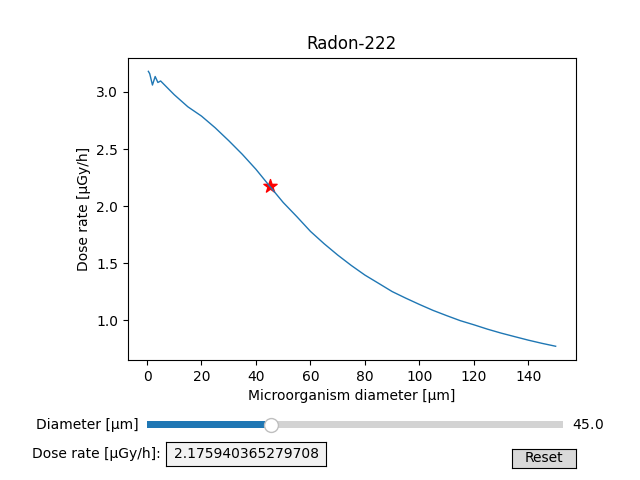

In [3]:
##############################################################################
# Button to hide the code
##############################################################################
toggle_cell_code("String_database")
# Define the index of the code cell containing the plot
plot_cell_index = 59

##############################################################################
# FUNCTION TO ACCESS AND EXTRACT DATA FROM THE DATABASE
##############################################################################
def database_run():
    try :
        dataBase = mysql.connector.connect(
            host = "localhost",
            user = "marim",
            database = "marim"
        )
        if dataBase.is_connected():
                db_Info = dataBase.get_server_info()
                print("Connected to MySQL Server version ", db_Info)

                cursor = dataBase.cursor()
                cursor.execute("SELECT edep_per_decay FROM internal_dose_water_"+dropdown_radionuclide.value+";")
                record = np.array(cursor.fetchall(), dtype=float)
                EdepInt = [a[0] for a in record]

                cursor = dataBase.cursor()
                cursor.execute("SELECT microdiameterum FROM dose_water_"+dropdown_radionuclide.value+";")
                record = np.array(cursor.fetchall(), dtype=float)
                Diameter_microbe = [a[0] for a in record]

                cursor = dataBase.cursor()
                cursor.execute("SELECT matrixradiusum FROM dose_water_"+dropdown_radionuclide.value+";")
                record = np.array(cursor.fetchall(), dtype=float)
                Radius_env = [a[0] for a in record]

#               Extracting EDEP values from water tables
                cursor = dataBase.cursor()
                cursor.execute("SELECT edep_per_decay FROM dose_water_"+dropdown_radionuclide.value+";")
                record = np.array(cursor.fetchall(), dtype=float)
                EdepWater = [a[0] for a in record]
                
#               Extracting EDEP values from mix 1:1 tables
                cursor = dataBase.cursor()
                cursor.execute("SELECT edep_per_decay FROM dose_50_"+dropdown_radionuclide.value+";")
                record = np.array(cursor.fetchall(), dtype=float)  
                EdepMix = [a[0] for a in record]
                
#               Extracting EDEP values from sediments tables
                cursor = dataBase.cursor()
                cursor.execute("SELECT edep_per_decay FROM dose_quartz_"+dropdown_radionuclide.value+";")
                record = np.array(cursor.fetchall(), dtype=float)
                EdepSed = [a[0] for a in record]
               
                print("You're connected to database:")

    except Error as e:
        print("Error while connecting to MySQL", e)
    finally:
        if dataBase.is_connected():
            cursor.close()
            dataBase.close()
        return [EdepInt,Diameter_microbe,Radius_env,EdepWater,EdepMix,EdepSed]
        
EdepInt,Diameter_microbe,Radius_env,EdepWater,EdepMix,EdepSed = database_run()

energy_int = np.array(EdepInt)
Array_diam_micro = np.array(Diameter_microbe)
Microorg_Vol_cm3 = pow(Array_diam_micro/2,3)*4/3*math.pi*1e-12
Array_Radius_env = np.array(Radius_env)
Env_Volume_cm3 = (pow(Array_Radius_env,3)*4/3*math.pi*1e-12)-Microorg_Vol_cm3

##############################################################################
# FUNCTION TO INTERPOLATE THE MATRIX DENSITY
##############################################################################
def interpolate_density(x_data, y_data, x):
    degree = 2 # Degree of the polynomial
    coefficients = np.polyfit(x_data, y_data, degree)
    # Generate fitted polynomial using the coefficients
    fitted_poly = np.poly1d(coefficients)
    y = fitted_poly(x)
    return y

# Densities for water,mix,sediments
X_list = [1.00, 1.8, 2.65]

# Initialize an empty list to store the Y arrays
Y_list = []

# Iterate over the arrays and create Y for each iteration
for edep_w, edep_m, edep_s in zip(EdepWater, EdepMix, EdepSed):
    Y = [edep_w, edep_m, edep_s]                 # Create Y array using values from the current iteration
    Y_list.append(Y)                             # Add Y to the list

# Initialize an empty list to store the interpolated values
interpolated_values = []

# Iterate over each Y array in Y_list
for Y in Y_list:
    # Perform interpolation using numpy.interp()
    interpolated = interpolate_density(X_list,Y,slider.value)
    interpolated_values.append(interpolated)

# Convert interpolated_values to a numpy array
interpolated_values = np.array(interpolated_values)

if dropdown_exposure.value == 'external' :
    print("EXTERNAL")
    Activity_vol = Env_Volume_cm3
    Edep_MeV = interpolated_values

if dropdown_exposure.value == 'internal' :
    Edep_MeV = energy_int
    Activity_vol = Microorg_Vol_cm3
    print("INTERNAL")

Edep_J = Edep_MeV*1.60217733E-13

Env_Volume_m3=Activity_vol*1e-6
Env_Volume_L=Activity_vol*0.001
Env_Mass_kg=Activity_vol*slider.value*0.001

Micro_Mass_kg=Microorg_Vol_cm3*0.001

Dose_to_micro = Edep_J/Micro_Mass_kg


if input4_widgets.value == 'Bq/L' :
   DoseRate = Dose_to_micro*bounded_Activity.value*Env_Volume_L*3600

if input4_widgets.value == 'Bq/kg' :
   DoseRate = Dose_to_micro*bounded_Activity.value*Env_Mass_kg*3600

if input4_widgets.value == 'Bq/m\u00b3' :
   DoseRate = Dose_to_micro*bounded_Activity.value*Env_Volume_m3*3600


#print("Dose to microorganisms in uGy: ",Dose_to_micro)
#in uGy
DoseRate=DoseRate*1e6

##############################################################################
# INTERPOLATING THE GEOMETRY
##############################################################################
def interpolate_and_extrapolate(x_data, y_data, x):
    if 0.5 < x < 150:
        f = interp1d(x_data, y_data)
        y = f(x)
    else:
        f = interp1d(x_data, y_data, fill_value="extrapolate")
        y = f(x)
    return y

# Create the figure and the line that we will manipulate

fig, ax = plt.subplots()

line, = ax.plot(Diameter_microbe, DoseRate, lw=1)
point = ax.scatter(bounded_diameter.value, interpolate_and_extrapolate(Diameter_microbe, DoseRate, bounded_diameter.value), marker='*', color='red', s=100)

ax.set_title('Dose rate assessment', pad=30)
ax.set_xlabel('Microorganism diameter [\u03BCm]')
ax.set_ylabel('Dose rate [\u03BCGy/h]')

plt.title(dropdown_radionuclide.label)


# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.20, bottom=0.25)


# Make a horizontal slider to control the diameter.
axdiam = fig.add_axes([0.23, 0.1, 0.65, 0.03])
diam_slider = Slider( ax=axdiam, label='Diameter [\u03BCm]', valmin=0.5, valmax=150, valinit=bounded_diameter.value,)

axtext = plt.axes([0.26, 0.03, 0.25, 0.05])
text_box = TextBox(axtext, 'Dose rate [\u03BCGy/h]: ', initial=interpolate_and_extrapolate(Diameter_microbe, DoseRate, bounded_diameter.value))

print("Dose to microorganisms in uGy: ",interpolate_and_extrapolate(Diameter_microbe, Dose_to_micro, bounded_diameter.value))

# The function to be called anytime a slider's value changes
def update(value):
    diameter = diam_slider.val  # get the current slider value
    y = interpolate_and_extrapolate(Diameter_microbe, DoseRate, diameter)
    point.set_offsets([[diameter, y]])  # update the point position
    text_box.set_val("{:e}".format(y))
    axtext.set_text('Dose rate[\u03BCGy/h]: {:e}'.format(y))
    fig.canvas.draw_idle()
    
# register the update function with each slider
diam_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    diam_slider.reset()
        
button.on_clicked(reset)

plt.show()

<h1 style="font-size: 16px;">Considerations</h1>
<p>
<div style="text-align: justify;">
The dose assessment for environments other than pure water, pure quartz, or a 1:1 mixture was not directly simulated. Instead, an interpolation method was used. A dose dependent material density mathematical function was obtained by performing Gate simulations for mixtures with different ratios (90%, 80%, 70%, and 60% in water) while varying the density. It's important to note that this study focused on a single radionuclide and one specific geometry. This curve serves as a reference for calculating the dose in these environments by interpolating within the curve. It's crucial to clarify that the dose values for these environments are not the direct result of Monte Carlo simulations but rather obtained through the interpolation method.
This approach was adopted due to the significant time and computational resources required to perform this study for all possible geometries and sizes. By leveraging the dose-density curve and interpolation, the dose assessment can be efficiently extrapolated to various environments while maintaining a reasonable level of accuracy.
</div>
</p>
</h1>

## Defining mathematicals functions

To estimate the dose using the simulations values we used the function interpolate 1D inside the range of 0.5 to 150 um diameter. When it is outside this range is used the extrapolate verison of it (only considered the limit 0 to 250 um).

### Interpolate / extrapolate python functions

Uses:

1. To evaluate the dose for any microorganism

2. To generate the intermediate density values not simulated


In [5]:
# DEFINING INTERPOLATION-EXTRAPOLATION FUNCTIONS
f = interp1d(x_data, y_data)
y = f(x)

<style>
.text-justify {
  text-align: center;
}
</style>

<h1 style="font-size: 40px;" class="text-justify">Contact Information</h1>

<h1 style="font-size: 26px;" class="text-justify">
    
<p class="fragment highlight-red">PhD. Giovanna R. Fois
<br>
giovanna.fois@clermont.in2p3.fr
</p>

<p> 
<div style="text-align: justify;">
M.Sc. Dariana LLanes-Vega
<br>
dariana.llanes@clermont.in2p3.fr
</div>
</p>

<p>
<div style="text-align: justify;">
PhD. Lydia Maigne
<br>
lydia.maigne@clermont.in2p3.fr
</div>
</p>

<p>
<div style="text-align: justify;">
Université Clermont Auvergne, CNRS/IN2P3, LPC, F-63000 Clermont-Ferrand, France
</div>
</p>

</h1>


<div style="text-align: center;">
    <div>
        <img src="LPC_logo.png" alt="Seba y Chispy" style="display: block; margin: 0 auto; width: 1000px;">
    </div>
</div>